# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217393

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.x, self.x_hat) #tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            loss = tf.where(tf.is_nan(self.regularized_loss), 1e-2, self.regularized_loss)
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            
            for epoch in range(1, (epochs+1)):
                #print("Step {} | Training Loss:".format(epoch), end = " " )
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    
                    def train_batch():
                        nonlocal train_loss
                        _, train_loss = sess.run([net.train_op, 
                                                  net.regularized_loss, 
                                                  ], #net.summary_op
                                                  feed_dict={net.x: x_train[i,:], 
                                                             net.y_: y_train[i,:], 
                                                             net.keep_prob:1})

                    train_batch()
                    
                    count = 10
                    if((train_loss > 1e4 or np.isnan(train_loss) ) and epoch > 1 and count < 1):
                        print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                        net.saver.restore(sess, 
                                          tf.train.latest_checkpoint('dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}'
                                                                     .format(epochs,h,f)))
                        train_batch()
                        count -= 1
                        
                    #summary_writer_train.add_summary(summary_str, epoch)
                    #if(train_loss > 1e9):
                    
                    #print("{:.6f}".format(train_loss), end = ", " )
                    
                #print("")
                valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1})
                    
                
                accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                               net.pred, 
                                                               net.actual, net.y], 
                                                              feed_dict={net.x: preprocess.x_test, 
                                                                         net.y_: preprocess.y_test, 
                                                                         net.keep_prob:1})
                #print("*************** \n")
                print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, test_loss, accuracy))
                #print("*************** \n")
                #print("Accuracy on Test data: {}".format(accuracy))

                
                if accuracy > Train.best_acc:
                    Train.best_acc = accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                    
                    #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                    #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                    #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                    #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})
                    
                    if not (np.isnan(train_loss)):
                        net.saver.save(sess, 
                                   "dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}/model"
                                   .format(epochs,h,f), 
                                   global_step = epoch, 
                                   write_meta_graph=False)
                    
                    curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                    Train.predictions.update({"{}_{}_{}".format(epochs,f,h):
                                              (curr_pred, 
                                               Train.result(epochs, f, h,valid_accuracy, accuracy))})

            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [100]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:100 hidden layers:2 features count:4
Step 1 | Training Loss: 0.384459 | Test Loss: 1.533378 | Test Accuracy: 0.803407
Step 2 | Training Loss: 0.247638 | Test Loss: 1.271418 | Test Accuracy: 0.810282
Step 3 | Training Loss: 0.523086 | Test Loss: 1.410251 | Test Accuracy: 0.794225
Step 4 | Training Loss: 0.245564 | Test Loss: 1.355747 | Test Accuracy: 0.787881
Step 5 | Training Loss: 0.177735 | Test Loss: 1.374732 | Test Accuracy: 0.762997
Step 6 | Training Loss: 0.352172 | Test Loss: 1.338143 | Test Accuracy: 0.796221
Step 7 | Training Loss: 0.704250 | Test Loss: 1.317026 | Test Accuracy: 0.772090
Step 8 | Training Loss: 0.230779 | Test Loss: 1.357148 | Test Accuracy: 0.782071
Step 9 | Training Loss: 0.392297 | Test Loss: 1.295085 | Test Accuracy: 0.770138
Step 10 | Training Loss: 0.137825 | Test Loss: 1.332437 | Test Accuracy: 0.749068
Step 11 | Training Loss: 0.193066 | Test Loss: 1.367272 | Test Accuracy: 0.777679
Step 12 | Training Loss: 0.439224 | 

Step 1 | Training Loss: 0.619020 | Test Loss: 1.248809 | Test Accuracy: 0.780518
Step 2 | Training Loss: 0.267994 | Test Loss: 1.228233 | Test Accuracy: 0.780607
Step 3 | Training Loss: 0.205088 | Test Loss: 1.149991 | Test Accuracy: 0.792229
Step 4 | Training Loss: 1.280090 | Test Loss: 1.165473 | Test Accuracy: 0.798084
Step 5 | Training Loss: 0.280400 | Test Loss: 2.286943 | Test Accuracy: 0.764594
Step 6 | Training Loss: 0.331178 | Test Loss: 426850651788541952.000000 | Test Accuracy: 0.810326
Step 7 | Training Loss: 0.376267 | Test Loss: 1.617893 | Test Accuracy: 0.832150
Step 8 | Training Loss: 0.486785 | Test Loss: 1.269559 | Test Accuracy: 0.795999
Step 9 | Training Loss: 0.188366 | Test Loss: 1.210629 | Test Accuracy: 0.802165
Step 10 | Training Loss: 0.469673 | Test Loss: 1.214636 | Test Accuracy: 0.759005
Step 11 | Training Loss: 0.223356 | Test Loss: 1.179432 | Test Accuracy: 0.763618
Step 12 | Training Loss: 0.129866 | Test Loss: 1.181829 | Test Accuracy: 0.763440
Step 13 

Step 1 | Training Loss: 0.626001 | Test Loss: 1.764891 | Test Accuracy: 0.795511
Step 2 | Training Loss: 0.695514 | Test Loss: 1.750721 | Test Accuracy: 0.809705
Step 3 | Training Loss: 0.479492 | Test Loss: 1.718943 | Test Accuracy: 0.752972
Step 4 | Training Loss: 0.535962 | Test Loss: 1.689275 | Test Accuracy: 0.757496
Step 5 | Training Loss: 0.533097 | Test Loss: 1.559718 | Test Accuracy: 0.769917
Step 6 | Training Loss: 0.501231 | Test Loss: 1.562867 | Test Accuracy: 0.772756
Step 7 | Training Loss: 0.535864 | Test Loss: 1.521429 | Test Accuracy: 0.745431
Step 8 | Training Loss: 0.456684 | Test Loss: 1.548683 | Test Accuracy: 0.778123
Step 9 | Training Loss: 0.455738 | Test Loss: 1.733833 | Test Accuracy: 0.775240
Step 10 | Training Loss: 0.567605 | Test Loss: 1.717416 | Test Accuracy: 0.767965
Step 11 | Training Loss: 0.445930 | Test Loss: 1.766691 | Test Accuracy: 0.745165
Step 12 | Training Loss: 0.419813 | Test Loss: 1.732484 | Test Accuracy: 0.792140
Step 13 | Training Loss: 

Step 6 | Training Loss: 0.583164 | Test Loss: 1.393577 | Test Accuracy: 0.775905
Step 7 | Training Loss: 0.174967 | Test Loss: 1.404928 | Test Accuracy: 0.759936
Step 8 | Training Loss: 0.097741 | Test Loss: 1.199573 | Test Accuracy: 0.753371
Step 9 | Training Loss: 0.130353 | Test Loss: 1.384366 | Test Accuracy: 0.750089
Step 10 | Training Loss: 0.269215 | Test Loss: 1.399238 | Test Accuracy: 0.749911
Step 11 | Training Loss: 0.051724 | Test Loss: 1.400853 | Test Accuracy: 0.789700
Step 12 | Training Loss: 0.219505 | Test Loss: 1.420250 | Test Accuracy: 0.742370
Step 13 | Training Loss: 0.310551 | Test Loss: 1.444661 | Test Accuracy: 0.731281
Step 14 | Training Loss: 0.091303 | Test Loss: 1.454284 | Test Accuracy: 0.720724
Step 15 | Training Loss: 0.348257 | Test Loss: 1.486715 | Test Accuracy: 0.721079
Step 16 | Training Loss: 1.019738 | Test Loss: 1.522114 | Test Accuracy: 0.716377
Step 17 | Training Loss: 0.140713 | Test Loss: 1.483016 | Test Accuracy: 0.744766
Step 18 | Training L

Step 13 | Training Loss: 0.297938 | Test Loss: 2.395646 | Test Accuracy: 0.646026
Step 14 | Training Loss: 1.437182 | Test Loss: 2.587249 | Test Accuracy: 0.720768
Step 15 | Training Loss: 0.195186 | Test Loss: 1.563657 | Test Accuracy: 0.787305
Step 16 | Training Loss: 0.543038 | Test Loss: 1.803699 | Test Accuracy: 0.839469
Step 17 | Training Loss: 0.403719 | Test Loss: 1.741393 | Test Accuracy: 0.826162
Step 18 | Training Loss: 0.337798 | Test Loss: 1.736630 | Test Accuracy: 0.830376
Step 19 | Training Loss: 0.650283 | Test Loss: 1.726830 | Test Accuracy: 0.829489
Step 20 | Training Loss: 0.446807 | Test Loss: 2.055157 | Test Accuracy: 0.839824
Step 21 | Training Loss: 0.481162 | Test Loss: 2.898079 | Test Accuracy: 0.856458
Step 22 | Training Loss: 1.948886 | Test Loss: 1.681496 | Test Accuracy: 0.854862
Step 23 | Training Loss: 0.339468 | Test Loss: 1.713174 | Test Accuracy: 0.871318
Step 24 | Training Loss: 0.443705 | Test Loss: 1.731594 | Test Accuracy: 0.856725
Step 25 | Traini

Step 15 | Training Loss: 0.272696 | Test Loss: 1.656305 | Test Accuracy: 0.862491
Step 16 | Training Loss: 2.167497 | Test Loss: 1.652878 | Test Accuracy: 0.859430
Step 17 | Training Loss: 0.500568 | Test Loss: 1.649340 | Test Accuracy: 0.830332
Step 18 | Training Loss: 0.346444 | Test Loss: 1.743773 | Test Accuracy: 0.800390
Step 19 | Training Loss: 0.607198 | Test Loss: 1.718194 | Test Accuracy: 0.811036
Step 20 | Training Loss: 0.350957 | Test Loss: 1.731444 | Test Accuracy: 0.818621
Step 21 | Training Loss: 0.703021 | Test Loss: 1.809503 | Test Accuracy: 0.843417
Step 22 | Training Loss: 0.383888 | Test Loss: 1.707352 | Test Accuracy: 0.868213
Step 23 | Training Loss: 0.479404 | Test Loss: 1.759620 | Test Accuracy: 0.829045
Step 24 | Training Loss: 0.294838 | Test Loss: 1.716016 | Test Accuracy: 0.851668
Step 25 | Training Loss: 0.635159 | Test Loss: 1.847852 | Test Accuracy: 0.804959
Step 26 | Training Loss: 0.592915 | Test Loss: 1.853323 | Test Accuracy: 0.767388
Step 27 | Traini

Step 20 | Training Loss: 0.885240 | Test Loss: 1.982711 | Test Accuracy: 0.430758
Step 21 | Training Loss: 0.737717 | Test Loss: 1.983173 | Test Accuracy: 0.430758
Step 22 | Training Loss: 0.805977 | Test Loss: 1.983631 | Test Accuracy: 0.430758
Step 23 | Training Loss: 0.712358 | Test Loss: 1.983490 | Test Accuracy: 0.430758
Step 24 | Training Loss: 0.821830 | Test Loss: 1.983486 | Test Accuracy: 0.430758
Step 25 | Training Loss: 0.831557 | Test Loss: 1.983799 | Test Accuracy: 0.430758
Step 26 | Training Loss: 0.857700 | Test Loss: 1.984073 | Test Accuracy: 0.430758
Step 27 | Training Loss: 0.909120 | Test Loss: 1.983846 | Test Accuracy: 0.430758
Step 28 | Training Loss: 0.876508 | Test Loss: 1.984031 | Test Accuracy: 0.430758
Step 29 | Training Loss: 1.016787 | Test Loss: 1.983041 | Test Accuracy: 0.430758
Step 30 | Training Loss: 0.999810 | Test Loss: 1.983847 | Test Accuracy: 0.430758
Step 31 | Training Loss: 1.161029 | Test Loss: 1.983999 | Test Accuracy: 0.430758
Step 32 | Traini

Step 20 | Training Loss: 0.642194 | Test Loss: 1.852695 | Test Accuracy: 0.780429
Step 21 | Training Loss: 0.699400 | Test Loss: 1.852849 | Test Accuracy: 0.738733
Step 22 | Training Loss: 0.692687 | Test Loss: 1.827217 | Test Accuracy: 0.750887
Step 23 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step 24 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step 25 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step 26 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step 27 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step 28 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step 29 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step 30 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step 31 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step 32 | Training Loss: nan | Test Loss:    nan | Test Accuracy: 0.569242
Step

Step 26 | Training Loss: 0.791287 | Test Loss: 1.983923 | Test Accuracy: 0.430758
Step 27 | Training Loss: 0.815244 | Test Loss: 1.984711 | Test Accuracy: 0.430758
Step 28 | Training Loss: 0.924163 | Test Loss: 1.985973 | Test Accuracy: 0.430758
Step 29 | Training Loss: 1.081409 | Test Loss: 1.983518 | Test Accuracy: 0.430758
Step 30 | Training Loss: 0.860965 | Test Loss: 1.983073 | Test Accuracy: 0.430758
Step 31 | Training Loss: 0.852655 | Test Loss: 1.983710 | Test Accuracy: 0.430758
Step 32 | Training Loss: 1.029282 | Test Loss: 1.982590 | Test Accuracy: 0.430758
Step 33 | Training Loss: 0.890896 | Test Loss: 1.983730 | Test Accuracy: 0.430758
Step 34 | Training Loss: 0.866184 | Test Loss: 1.983332 | Test Accuracy: 0.430758
Step 35 | Training Loss: 1.113015 | Test Loss: 1.983774 | Test Accuracy: 0.430758
Step 36 | Training Loss: 0.900605 | Test Loss: 1.983039 | Test Accuracy: 0.430758
Step 37 | Training Loss: 0.913290 | Test Loss: 1.983125 | Test Accuracy: 0.430758
Step 38 | Traini

Step 26 | Training Loss: 0.659133 | Test Loss: 1.822496 | Test Accuracy: 0.866749
Step 27 | Training Loss: 0.638845 | Test Loss: 1.808234 | Test Accuracy: 0.813343
Step 28 | Training Loss: 0.661396 | Test Loss: 1.794670 | Test Accuracy: 0.805802
Step 29 | Training Loss: 0.725138 | Test Loss: 1.809027 | Test Accuracy: 0.785043
Step 30 | Training Loss: 0.507504 | Test Loss: 1.801346 | Test Accuracy: 0.805137
Step 31 | Training Loss: 0.612397 | Test Loss: 1.806494 | Test Accuracy: 0.780696
Step 32 | Training Loss: 0.622804 | Test Loss: 1.789462 | Test Accuracy: 0.801677
Step 33 | Training Loss: 0.670715 | Test Loss: 1.790710 | Test Accuracy: 0.793426
Step 34 | Training Loss: 0.746469 | Test Loss: 1.791449 | Test Accuracy: 0.785397
Step 35 | Training Loss: 0.698536 | Test Loss: 1.795750 | Test Accuracy: 0.815472
Step 36 | Training Loss: 0.792834 | Test Loss: 1.826619 | Test Accuracy: 0.777812
Step 37 | Training Loss: 0.690955 | Test Loss: 1.814235 | Test Accuracy: 0.774574
Step 38 | Traini

Step 31 | Training Loss: 1.022943 | Test Loss: 1.940057 | Test Accuracy: 0.472010
Step 32 | Training Loss: 0.763033 | Test Loss: 1.938905 | Test Accuracy: 0.472099
Step 33 | Training Loss: 0.923087 | Test Loss: 1.938682 | Test Accuracy: 0.471833
Step 34 | Training Loss: 1.741883 | Test Loss: 1.941228 | Test Accuracy: 0.471833
Step 35 | Training Loss: 0.988240 | Test Loss: 1.959172 | Test Accuracy: 0.440472
Step 36 | Training Loss: 0.830016 | Test Loss: 1.958054 | Test Accuracy: 0.607656
Step 37 | Training Loss: 0.851921 | Test Loss: 1.956193 | Test Accuracy: 0.440073
Step 38 | Training Loss: 0.939446 | Test Loss: 1.953362 | Test Accuracy: 0.440161
Step 39 | Training Loss: 0.716382 | Test Loss: 1.955995 | Test Accuracy: 0.439984
Step 40 | Training Loss: 0.770276 | Test Loss: 1.955936 | Test Accuracy: 0.611338
Step 41 | Training Loss: 0.678908 | Test Loss: 1.953713 | Test Accuracy: 0.440916
Step 42 | Training Loss: 0.783103 | Test Loss: 1.954714 | Test Accuracy: 0.442912
Step 43 | Traini

KeyboardInterrupt: 

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)
    

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
4,100,4,4,0.870694,0.902014
5,100,8,4,0.943880,0.888086
9,100,8,6,0.927766,0.866749
8,100,4,6,0.959994,0.843506
2,100,16,2,0.943562,0.837961
11,100,32,6,0.921337,0.837917
10,100,16,6,0.914351,0.836631
1,100,8,2,0.913161,0.832150
6,100,16,4,0.959438,0.823589
0,100,4,2,0.954517,0.821017


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.7354  0.2646]
 [ 0.0266  0.9734]]


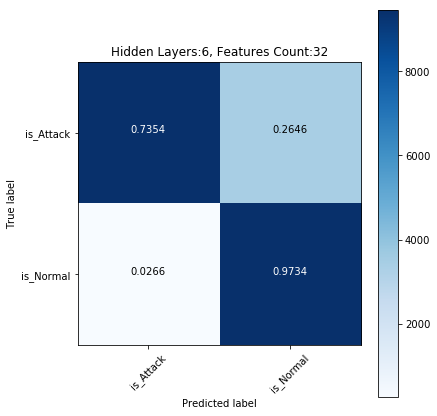

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)